In [20]:
import numpy as np
import pandas as pd
import collections
import re
import minisom
from collections import Counter
from sklearn.preprocessing import minmax_scale
from pylab import plot,axis,show,pcolor,colorbar,bone
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from minisom import MiniSom
from math import log

In [2]:
documents = pd.read_csv('D:/NN HW 2021/HW2/bbc-text.csv')
stop_words = pd.read_csv('D:/NN HW 2021/HW2/stopwords.txt', sep ='\t')
news_ducs = documents.loc[:]['text']
news_category = documents.loc[:]['category']
class_labels = news_category.unique()

for i in range(news_ducs.shape[0]):
    news_ducs[i]= re.sub("[^a-zA-Z ]+", "",news_ducs[i])
for i in range(news_ducs.shape[0]):
    news_ducs[i]= re.sub(r'\b\w{1,2}\b','',news_ducs[i])
category = np.zeros(len(news_category), dtype=int)
news_category_array = news_category.to_numpy(news_category)
category[news_category_array == 'business'] = 0
category[news_category_array == 'entertainment'] = 1
category[news_category_array == 'politics'] = 2
category[news_category_array == 'sport'] = 3
category[news_category_array == 'tech'] = 4
stopw = list(stop_words.columns)[0].split()
docs_list = []
docs_list_split = []
for txt in news_ducs:
    txt = txt.split()
    txt_n = ""
    for word in txt:
        if(word in stopw) == False:
            txt_n =txt_n+word+" "
    docs_list_split.append(txt_n.split())
    docs_list.append(txt_n)

In [3]:
def tfidf(doc, _corpus):
    dic = collections.defaultdict(int)
    for x in _corpus:
        for y in x:
            dic[y] += 1.
    return {x: doc[x] * log(len(_corpus) / dic[x]) for x in doc}

doc_sets = [Counter(doc.split()) for doc in docs_list]
docs_list_tfidf = [tfidf(x, doc_sets) for x in doc_sets]
df_tfidf_docs = pd.DataFrame(docs_list_tfidf)
df_tfidf_docs =  df_tfidf_docs.fillna(0)
data = df_tfidf_docs.to_numpy()
for i in range(data.shape[0]):
    temp = data[i]
    data[i] = minmax_scale(temp,feature_range=(0,1))
sample_num, words_num = df_tfidf_docs.shape

In [12]:
map_size = (1,5) #(3,3) (4,4) , (5,5)
if map_size == (1,5):
    som = MiniSom(map_size[0], map_size[1], words_num, sigma=3, learning_rate=0.25,
                activation_distance='euclidean')
    som.random_weights_init(data)
    som.train_batch(data, 15000, verbose=True)
else:
    som = MiniSom(map_size[0], map_size[1], words_num, sigma= 4, learning_rate=0.25,
                neighborhood_function='gaussian',topology='hexagonal', 
                activation_distance='euclidean')
    som.random_weights_init(data)
    som.train_batch(data, 10000, verbose=True)

C:\Users\Parisan\Anaconda3\lib\site-packages\minisom.py:154: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.4370490078199047


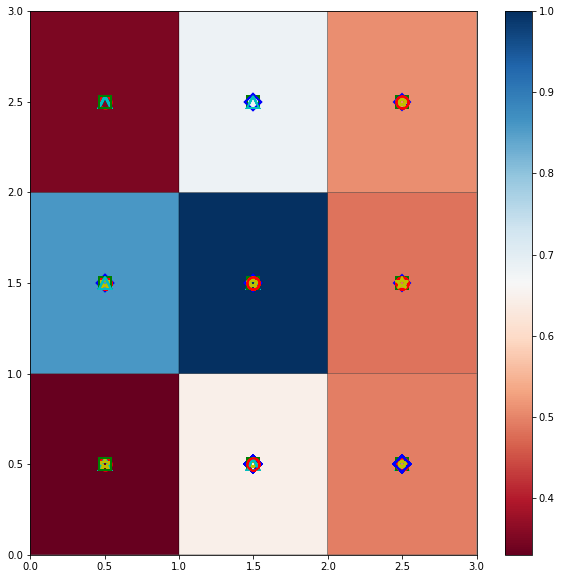

       0      1      2
0  215.0  439.0  129.0
1  295.0  252.0   16.0
2  583.0  229.0   67.0


In [13]:
plt.figure(figsize=(10, 10))
pcolor(som.distance_map().T,cmap='RdBu' ,edgecolors='k') # distance map as background
colorbar()
markers = ['o','s','D','^' , '*' ]
colors = ['r','g','b','c','y']
for cnt,xx in enumerate(data):
  w = som.winner(xx) 
  plot(w[0]+.5,w[1]+.5,markers[category[cnt]],markerfacecolor='None',
       markeredgecolor=colors[category[cnt]],markersize=12,markeredgewidth=2)
show()
winner_coordinates = np.array([som.winner(x) for x in data]).T
frequencies = som.activation_response(data)
print(pd.DataFrame(frequencies))

In [14]:
def compute_result_SOM_WTA():
    label_names = {0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
    labels_map = som.labels_map(data, [label_names[t] for t in category])
    fig = plt.figure(figsize=(4, 4))
    the_grid = gridspec.GridSpec(map_size[0], map_size[1], fig)
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in label_names.values()]
        plt.subplot(the_grid[position], aspect=1)
        patches, texts = plt.pie(label_fracs)
    plt.legend(patches, label_names.values(), bbox_to_anchor=(3,3), ncol=3)
    plt.title('each neuron details')
    show()
    #Compute Confiuosion matrix
    for obj in labels_map.keys():
        print(obj ,labels_map[obj])
    nerouns_dict = dict()
    for neuron in labels_map.keys():
        tmp = max(labels_map[neuron].values())
        label = [name for name, counter in labels_map[neuron].items() if counter == tmp]
        nerouns_dict[neuron] = [label[0] , tmp, sum(labels_map[neuron].values())]
    confusion_matrix = np.zeros((5,4))
    names_to_class = {'business':0, 'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
    for neuron , detail in nerouns_dict.items():
        confusion_matrix[neuron[1]][0] = (len(category) - detail[2])/len(category) #compute accuracy
        confusion_matrix[neuron[1]][1] = detail[1]/(detail[1] + detail[2]) #compute precision
        confusion_matrix[neuron[1]][2] = detail[1]/len(category[category == names_to_class[detail[0]]]) #compute recall
        confusion_matrix[neuron[1]][3] = 2 * confusion_matrix[neuron[1]][2]*confusion_matrix[neuron[1]][1]/(
                                            confusion_matrix[neuron[1]][2]+confusion_matrix[neuron[1]][1]) #compute f1-score    
    confusion_df = pd.DataFrame(confusion_matrix,index = names_to_class.keys(), 
                                columns=['accuracy','precision','recall','f1-score'])
    print('\n', confusion_df)

In [17]:
def compute_result_SOM_OnCenter():
    label_names = {0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
    labels_map = som.labels_map(data, [label_names[t] for t in category])
    fig = plt.figure(figsize=(6, 6))
    the_grid = gridspec.GridSpec(map_size[0], map_size[1], fig)
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in label_names.values()]
        plt.subplot(the_grid[map_size[0]-1-position[1],
                            position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)

    plt.legend(patches, label_names.values(), bbox_to_anchor=(2,2), ncol=3)
    w_x, w_y = zip(*[som.winner(d) for d in data])
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    plt.figure(figsize=(10, 9))
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
    plt.colorbar()
    for c in np.unique(category):
        idx_target = category==c
        plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                    w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                    s=50, c=colors[c-1], label=label_names[c])
    plt.legend(bbox_to_anchor=(1.5,1))
    plt.grid()
    plt.show()
    labelmap_df = labels_map.items()
    labelmap_df = sorted(labelmap_df)
    for neroun , detail in labelmap_df:
        print(neroun ,detail)
    win_map = som.win_map(data)
    size=som.distance_map().shape[0]
    qualities=np.empty((size,size))
    qualities[:]=np.NaN
    for position, values in win_map.items():
        qualities[position[0], position[1]] = np.mean(abs(values-som.get_weights()[position[0], position[1]]))
    layout = go.Layout(title='quality plot')
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Heatmap(z=qualities, colorscale='Viridis'))
    fig.show()
    #compute  the Euclidean distance
    distance_nerouns = som.distance_map()
    distance_data =  som._distance_from_weights(data)
    dis_data_from_winner = dict()
    for count in range (len(data)):
        i, j = winner_coordinates[0][count] , winner_coordinates[1][count]
        dis_tmp = distance_data[count].reshape(map_size)[i][j]
        dis_data_from_winner[count] = dis_tmp
    sum_dis = sum(list(dis_data_from_winner.values()))
    print('\n\n final distance in SOM with size' , map_size)
    print('\t', sum_dis)

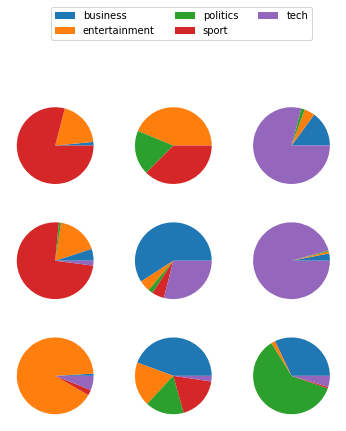

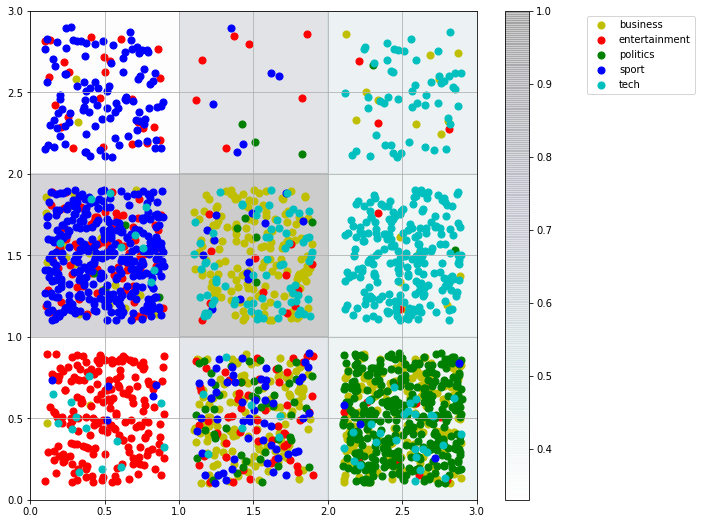

(0, 0) Counter({'entertainment': 195, 'tech': 13, 'sport': 5, 'business': 2})
(0, 1) Counter({'sport': 327, 'entertainment': 77, 'business': 22, 'tech': 9, 'politics': 4})
(0, 2) Counter({'sport': 102, 'entertainment': 25, 'business': 2})
(1, 0) Counter({'business': 131, 'entertainment': 55, 'sport': 54, 'politics': 48, 'tech': 7})
(1, 1) Counter({'business': 149, 'tech': 73, 'sport': 13, 'entertainment': 12, 'politics': 5})
(1, 2) Counter({'entertainment': 7, 'sport': 6, 'politics': 3})
(2, 0) Counter({'politics': 355, 'business': 187, 'tech': 27, 'entertainment': 10, 'sport': 4})
(2, 1) Counter({'tech': 219, 'business': 7, 'entertainment': 2, 'politics': 1})
(2, 2) Counter({'tech': 53, 'business': 10, 'entertainment': 3, 'politics': 1})




 final distance in SOM with size (3, 3)
	 5422.43404239928


In [18]:
if map_size == (1,5):
    compute_result_SOM_WTA()
else:
    compute_result_SOM_OnCenter()